In [2]:
from pathlib import Path

name = "librispeech-dev-clean"
in_dir = Path("data/dev-clean")
align_dir = Path("data/alignments/dev-clean")
feat_dir = Path("features")
audio_ext = ".flac" 

In [18]:
from encode import sample_files
from utils.features import DataSet

dataset = DataSet(
    name, in_dir, align_dir, feat_dir, audio_ext 
)

sample_size = -1
gamma = 0.2
out_dir_dusted = Path(f"output/dusted/{sample_size}")

sampled_paths = sample_files(dataset, sample_size)
print(len(sampled_paths))

2703


In [ ]:
from encode import get_units
from joblib import Parallel, delayed

# results = Parallel(n_jobs=2)([
#     delayed(get_units)(dataset, "dusted", sampled_paths, gamma, True),  
# ])
# dusted_words = results[0]

dusted_words = get_units(dataset, "dataset", sampled_paths, gamma, True)

Using cache found in /Users/daneladendorff/.cache/torch/hub/bshall_hubert_main
Getting units:  14%|█▍        | 378/2703 [01:25<20:37,  1.88it/s]

In [5]:
from utils.features import load_units_from_paths
from joblib import Parallel, delayed

results = Parallel(n_jobs=2)([
    delayed(load_units_from_paths)(dataset, "dusted", sampled_paths, gamma=0.2),  
])

dusted_words = results[0]

KeyboardInterrupt: 

In [6]:
from distance import calculate_distance

# If calculate_distance is called with only the words, it does not save the matrices
dist_mat_dusted = calculate_distance(dusted_words, out_dir_dusted, 1)

Calculating Distances: 100%|██████████| 2683086/2683086 [00:09<00:00, 286801.56it/s]


[[0.         1.         1.         1.         1.        ]
 [1.         0.         1.         0.94736842 0.84210526]
 [1.         1.         0.         1.         1.        ]
 [1.         0.94736842 1.         0.         1.        ]
 [1.         0.84210526 1.         1.         0.        ]]


In [6]:
from utils.features import get_words_and_dist_mat

dusted_words, dist_mat_dusted = get_words_and_dist_mat(dataset, "dusted", out_dir_dusted, sample_size, gamma)

FileNotFoundError: [Errno 2] No such file or directory: 'output/dusted/50/words.csv'

In [7]:
from utils.features import display_words

true_words = display_words(dusted_words)

Sorted Word Counts


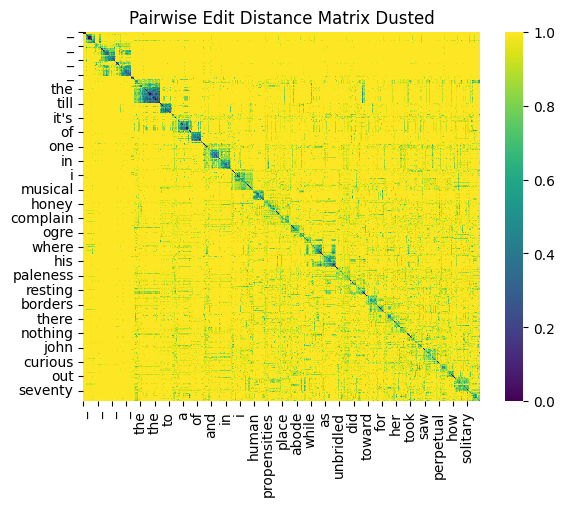

In [8]:
from eval import pairwise_edit_dist_mat

# Visualise the distances
pairwise_edit_dist_mat(dist_mat_dusted, "Pairwise Edit Distance Matrix Dusted", true_words)

In [9]:
from cluster import cluster, get_word_clusters

# Get the int_clusters for each of the matrices
dust_clusters = cluster(dist_mat_dusted, 0.2)

# Convert these to word clusters
dust_word_clusters = get_word_clusters(dust_clusters, dusted_words)

Getting Word Clusters: 100%|██████████| 2014/2014 [00:00<00:00, 11470.51it/s]


In [10]:
from cluster import get_loaded_clusters

dust_word_clusters = get_loaded_clusters(dusted_words)

In [11]:
from eval import ned

# Compute the ned for my dusted and hubert clusters - atm my NED is computed only using clusters with > 1 words
ned_dusted = ned(dust_word_clusters, print_pure=False, print_inpure=True)
print(f"DUSTED NED: {ned_dusted}")

Calculating NED: 100%|██████████| 2014/2014 [00:00<00:00, 425600.98it/s]

Cluster 57: 0.5555555555555556
a, it, a, at, a, a, a, a, a, a

Cluster 182: 0.27586206896551724
the, though, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the

Cluster 215: 2
no, know

Cluster 304: 2
that, the

Cluster 315: 0.6666666666666666
had, had, head

Cluster 482: 2
he, who

Cluster 762: 2
their, there

Cluster 1015: 3
the, a

Cluster 1052: 3
the, a

Cluster 1089: 1.2
in, in, and, in, and, and

DUSTED NED: 0.11561866125760649


In [12]:
from cluster import get_best_clusters

ned_dusted, duplicate_count_dusted, dust_word_clusters = get_best_clusters(dust_word_clusters, ned_dusted, max_iter=5)

Iteration 0: NED: 0.115619, Duplicates: 1328


Calculating NED: 100%|██████████| 2014/2014 [00:00<00:00, 2432285.71it/s]


Iteration 1: NED: 0.065112


Calculating NED: 100%|██████████| 2014/2014 [00:00<00:00, 2411455.40it/s]


Iteration 2: NED: 0.057505


Calculating NED: 100%|██████████| 2014/2014 [00:00<00:00, 2462060.12it/s]


Iteration 3: NED: 0.060513


Calculating NED: 100%|██████████| 2014/2014 [00:00<00:00, 2579336.87it/s]

Iteration 4: NED: 0.061267
Converged early due to no significant improvement in NED or duplicate count.
Best NED: 0.060513, Best Duplicates: 1333


In [13]:
from utils.features import store_words

# Store words associated with these clusters
store_words(dust_word_clusters, out_dir_dusted)

Wrote words to output/dusted/100/words.csv


In [14]:
from eval import words_from_word_units, clusters_purity
            
dust_just_words_clusters = words_from_word_units(dust_word_clusters)
inpurity, total = clusters_purity(dust_just_words_clusters)
print(f"{total} Dusted Clusters with inpurity: {round(inpurity*100, 3)}%")

2014 Dusted Clusters with inpurity: 58.143%


In [15]:
from eval import calculate_duplicate_clusters

cluster_counts_dusted, duplicate_counts_dusted = calculate_duplicate_clusters(dust_word_clusters, print_clusters=True)

Total duplicate clusters (considering word frequency): 1333
Duplicate clusters and their counts:
{'_': 4}: 3 times
{'preface': 1}: 2 times
{'to': 1}: 40 times
{'_': 1}: 163 times
{'second': 1}: 2 times
{'_': 2}: 20 times
{'he': 1}: 24 times
{'did': 1}: 4 times
{'himself': 1}: 2 times
{'into': 1}: 7 times
{'the': 5}: 2 times
{'go': 1}: 2 times
{'out': 1}: 7 times
{'but': 1}: 17 times
{'when': 1}: 4 times
{'in': 1}: 18 times
{'thought': 1}: 3 times
{'saw': 1}: 2 times
{'man': 1}: 3 times
{'him': 1}: 4 times
{'and': 4}: 3 times
{'went': 1}: 2 times
{'was': 2}: 3 times
{'on': 1}: 12 times
{'with': 1}: 9 times
{'_': 10}: 2 times
{'and': 1}: 49 times
{'against': 1}: 2 times
{'it': 1}: 28 times
{'best': 1}: 2 times
{'therefore': 1}: 3 times
{'his': 1}: 17 times
{'arms': 1}: 2 times
{'head': 1}: 4 times
{'reserve': 1}: 2 times
{'for': 1}: 14 times
{'occasion': 1}: 2 times
{'_': 3}: 6 times
{'said': 1}: 7 times
{'she': 2}: 5 times
{'would': 1}: 6 times
{'them': 1}: 7 times
{'if': 1}: 5 times
{'

In [17]:
from encode import sample_files

query_path = sample_files(dataset, sample_size=1)

# Query one of the ladys
# query_path = [Path("data/dev-clean/174/50561/174-50561-0013.flac")]

from utils.features import load_units_from_paths
from encode import get_units

query_dusted_words = load_units_from_paths(dataset, "dusted", query_path, gamma=0.2)
if not query_dusted_words:
    query_dusted_words = get_units(dataset, "dusted", query_path, gamma=0.2, save=True)
query_dusted_sentence = " ".join([w.true_word for w in query_dusted_words])

from cluster import get_distance_to_centroids, get_cluster_centroids

dust_centroids = get_cluster_centroids(dust_word_clusters)
query_dusted_words = get_distance_to_centroids([query_dusted_words], dust_centroids)

import editdistance
import statistics

predictions = []
query_distances = []
for word in query_dusted_words:
    prediction = dust_centroids[word.cluster_id].true_word
    # print(" : ".join([word.true_word, prediction]))
    query_distances.append(editdistance.eval(word.true_word, prediction)/max(len(word.true_word), len(prediction)))
    predictions.append(prediction)

prediction_sentence = " ".join(predictions)
print(f"NED for query: {statistics.mean(query_distances)}")
print(query_dusted_sentence)
print(prediction_sentence)

Loading Units: 100%|██████████| 1/1 [00:00<00:00, 616.45it/s]
Using cache found in /Users/daneladendorff/.cache/torch/hub/bshall_dusted_main
Using cache found in /Users/daneladendorff/.cache/torch/hub/bshall_dusted_main
Using cache found in /Users/daneladendorff/.cache/torch/hub/bshall_hubert_main
Get Distances to Centroids: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]

NED for query: 0.4868097643097643
_ that enchantment had possessed him _ usurping as it were the throne of his life and displacing it _ when it ceased _ he was not his own master
_ that into _ best on _ see is a were the an a is i in still it _ an it _ _ a is not is on mister
